In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [19]:
import tensorflow as tf
import datetime

In [20]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1

# IMAGE_DIRECTORY = "../Datasets/HandWritten-Nist/dataset"
IMAGE_DIRECTORY = "../Datasets/MergedMNIST/dataset"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
	IMAGE_DIRECTORY,
	labels="inferred",
	label_mode="categorical", # one-hot encoding stuff
	image_size=(28, 28),
	shuffle=True,
	color_mode="grayscale",
)

# Split to train and test 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


Found 814255 files belonging to 47 classes.


In [21]:
# Normalize the dataset prior to the model

def normalize(image, label):
	image = tf.cast(image, tf.float32) / 255.0
	return image, label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)

In [22]:
# # Configuring the dataset for performance
# # Enable caching and prefetching (overlap preprocessing and model execution while training)
# AUTOTUNE = tf.data.AUTOTUNE

# # Set up a pre-processing function. It is just going to be normalizing here, but
# # that hopefully should save time later?
# def preprocess_image(image, label):
# 	image = image / 255.0
# 	return image, label

# # Cache to disk instead of memory because we got some large datasets
# dataset = dataset.cache('/tmp/dataset_cache')

# # Apply preprocessing
# # dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Prefetching..? Gotta be honest, this seems to help but idk how considering all
# # the images are local
# dataset = dataset.prefetch(buffer_size=2)

# train_ds = dataset.shuffle(1000)

# # train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # train_ds = dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache('/tmp/dataset_cache')
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
model = tf.keras.models.Sequential()

# Hypothesis by doing tanh here stems from
# 1) Observing that LeNet while simple uses it
# 2) The initial layers are looking for general features, not specific ones
model.add(tf.keras.layers.Conv2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
))

# Batch normalizationhelps helps train models faster. It does this in a few
# ways. It allows us (1) to increase the learning rate (2) it helps resolve the
# vanishing gradient problem somewhat (usually done by ReLU though) (3)
# regularization which helps prevent overfitting (we could remove the dropout
# layer possibly)
# https://www.datacamp.com/tutorial/batch-normalization-tensorflow
# https://arxiv.org/abs/1502.03167
# https://www.geeksforgeeks.org/what-is-batch-normalization-in-cnn/#how-does-batch-normalization-work-in-cnn
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2)
))


# Hypothesis by doing relu here is that this layer is going to be looking for
# more abstract features and they should be an off/on situation
model.add(tf.keras.layers.Conv2D(
    kernel_size=5,
    filters=16,
    strides=1,
))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

# LeNet uses 120 neurons, online example uses 128
# We will use 200
model.add(tf.keras.layers.Dense(
    units=200,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

# Output layer
model.add(tf.keras.layers.Dense(
    units=47,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

/mnt/c/Users/noahb/NProgramming/Handwriting-Recognition-CS584/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 24, 24, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 47)             │         9,447 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,367 (251.43 KB)

 Trainable params: 64,319 (251.25 KB)

 Non-trainable params: 48 (192.00 B)

In [50]:
# Compile the model

# Uses Adam. Adam works by
# - Keeping track of a history of gradients as opposed to just the current
#   gradient
# - It uses an adaptive learning rate based on that gradient history Adam is

# It also just generally efficient and works well for our use case (ChatGPT
# mentions good for computer vision tasks which is kind of what we are doing)

# We might try testing this with stochastic gradient descent instead because
# that is what we learned in class. We could use that as a storytelling aspect
# for the professor

# adam_optimizer = tf.keras.optimizers.Adam()
# model.compile(
#     optimizer=adam_optimizer,
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# In past experiments, SGD has performed better and it is apparently used in
# other image networks
# https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
sgd_optimizer = tf.keras.optimizers.SGD()
model.compile(
	optimizer=sgd_optimizer,
	loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [51]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    train_dataset,
    # y_train_re,
    epochs=25,
    # validation_data=(x_validation_normalized, y_validation_re),
    validation_data=val_dataset
    # callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7481 - loss: 0.8671 - val_accuracy: 0.8725 - val_loss: 0.3617
Epoch 2/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8693 - loss: 0.3771 - val_accuracy: 0.8827 - val_loss: 0.3280
Epoch 3/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.8789 - loss: 0.3448 - val_accuracy: 0.8864 - val_loss: 0.3166
Epoch 4/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8838 - loss: 0.3272 - val_accuracy: 0.8914 - val_loss: 0.2998
Epoch 5/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.8867 - loss: 0.3167 - val_accuracy: 0.8925 - val_loss: 0.2931
Epoch 6/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.8888 - loss: 0.3094 - val_accuracy: 0.8950 - val_loss: 0.2882
Epoch 7/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.8905 - loss: 0.3026 - val_accuracy: 0.8939 - val_loss: 0.2884
Epoch 8/25
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 

In [52]:
# Access training loss and accuracy
train_loss = training_history.history['loss']
train_accuracy = training_history.history['accuracy']

# Access validation loss and accuracy (if validation data is provided)
val_loss = training_history.history.get('val_loss')
val_accuracy = training_history.history.get('val_accuracy')

# Print statistics for each epoch
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss[epoch]:.4f}, Training Accuracy: {train_accuracy[epoch]:.4f}")
    if val_loss and val_accuracy:
        print(f"  Validation Loss: {val_loss[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1:
  Training Loss: 0.5611, Training Accuracy: 0.8214
  Validation Loss: 0.3617, Validation Accuracy: 0.8725
Epoch 2:
  Training Loss: 0.3701, Training Accuracy: 0.8713
  Validation Loss: 0.3280, Validation Accuracy: 0.8827
Epoch 3:
  Training Loss: 0.3421, Training Accuracy: 0.8796
  Validation Loss: 0.3166, Validation Accuracy: 0.8864
Epoch 4:
  Training Loss: 0.3270, Training Accuracy: 0.8838
  Validation Loss: 0.2998, Validation Accuracy: 0.8914
Epoch 5:
  Training Loss: 0.3167, Training Accuracy: 0.8867
  Validation Loss: 0.2931, Validation Accuracy: 0.8925
Epoch 6:
  Training Loss: 0.3097, Training Accuracy: 0.8886
  Validation Loss: 0.2882, Validation Accuracy: 0.8950
Epoch 7:
  Training Loss: 0.3039, Training Accuracy: 0.8901
  Validation Loss: 0.2884, Validation Accuracy: 0.8939
Epoch 8:
  Training Loss: 0.2989, Training Accuracy: 0.8918
  Validation Loss: 0.2853, Validation Accuracy: 0.8950
Epoch 9:
  Training Loss: 0.2954, Training Accuracy: 0.8928
  Validation Loss: 0

In [53]:
model_name_string = "model_v9_correct_batch_normal"

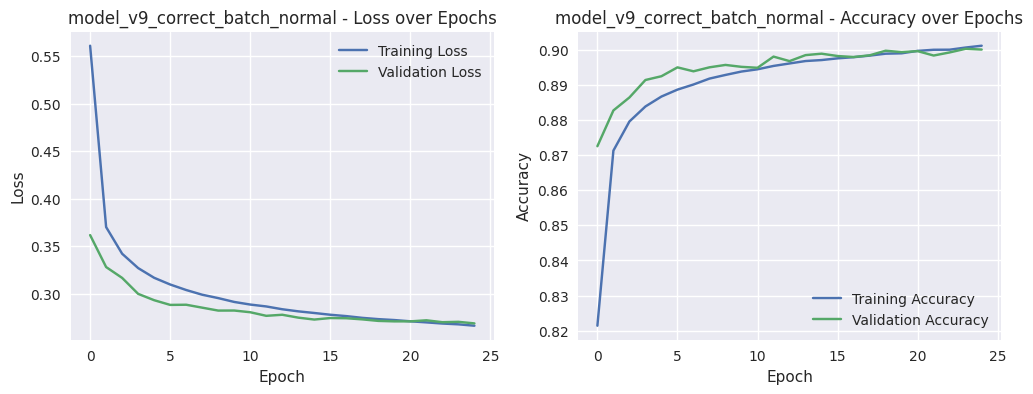

In [54]:
import matplotlib.pyplot as plt


# Plot training and validation loss

with plt.style.context("seaborn-v0_8"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['loss'], label='Training Loss')
    if 'val_loss' in training_history.history:
        plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name_string} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in training_history.history:
        plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name_string} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.style.use('seaborn-v0_8-bright')
    plt.legend()

    plt.show()

In [55]:
import pandas as pd

# Convert the history to a DataFrame and save as CSV
history_df = pd.DataFrame(training_history.history)
history_df.to_csv(f'{model_name_string}_history.csv', index=False)

In [56]:
# Save the model itself
model.save(f'{model_name_string}.keras')

In [57]:
# Save model weights
model.save_weights(f'{model_name_string}.weights.h5') 